# Librerias

In [1]:
#Librerias para trabajar los datos
import pandas as pd
import numpy as np


#Librerias para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de Datos

In [2]:
#Carga de los datos principales
value_types = {'codigo_muni':'string','codigo_depto':'string'}
df_main = pd.read_csv('data_generated/data_ready.csv',sep=',',index_col=False,low_memory=False,dtype=value_types)
df_main.head()

,anio,codigo_depto,nombre_depto,nombre_muni,codigo_muni,codigo_evento,evento,edad,sexo,num_casos,población
0,2020,05,Antioquia,Abejorral,05002,102,Tuberculosis,15-44 años,Hombres,1,4393
1,2020,05,Antioquia,Abejorral,05002,501,Accidentes de transporte terrestre,15-44 años,Hombres,1,4393
2,2020,05,Antioquia,Abejorral,05002,511,Lesiones autoinfligidas intencionalmente (suic...,15-44 años,Hombres,1,4393
3,2020,05,Antioquia,Abejorral,05002,512,Agresiones (homicidios),15-44 años,Hombres,1,4393
4,2020,05,Antioquia,Abejorral,05002,108,Infecciones respiratorias agudas,65+ años,Hombres,1,1358


# Creación de dimensiones y tabla de hechos

## Creación dimensión Fecha

In [3]:
#Creamos el dataframe
df_fecha = pd.DataFrame(df_main["anio"].unique())
df_fecha = df_fecha.reset_index()
df_fecha.columns = ["fecha_key", "anio"]
df_fecha["fecha_key"] = df_fecha["fecha_key"]+1

In [4]:
#Veamos el dataframe
df_fecha.head(5)

,fecha_key,anio
0,1,2020


In [5]:
#Guardamos la dimensión fecha
df_fecha.to_csv('data_generated/dim_fecha.csv',index = False)

## Creación dimensión Perfil

In [6]:
#obtengo edades y sexo unicas, luego creo a para hacer un join sin parametro
list_edad = pd.DataFrame(df_main["edad"].unique())
list_edad["a"] = "a"
list_sexo = pd.DataFrame(df_main["sexo"].unique())
list_sexo["a"] = "a"

mix1 = pd.merge(list_edad, list_sexo, on="a")
mix1.head(5)

,0_x,a,0_y
0,15-44 años,a,Hombres
1,15-44 años,a,Mujeres
2,65+ años,a,Hombres
3,65+ años,a,Mujeres
4,45-64 años,a,Hombres


In [7]:
#Creamos el dataframe
df_perfil = mix1.copy()
df_perfil = df_perfil.drop(columns=['a'])
df_perfil = df_perfil.reset_index()
df_perfil.columns = ["perfil_key","edad", "sexo"]
df_perfil["perfil_key"] = df_perfil["perfil_key"]+1
df_perfil.head(5)

,perfil_key,edad,sexo
0,1,15-44 años,Hombres
1,2,15-44 años,Mujeres
2,3,65+ años,Hombres
3,4,65+ años,Mujeres
4,5,45-64 años,Hombres


In [8]:
#Guardamos la dimensión perfil
df_perfil.to_csv('data_generated/dim_perfil.csv',index = False)

## Creación dimensión Lugar

In [9]:
#Vamos a usar otra fuente de datos para traer locaciones geograficas
value_types = {'codigo_muni':'string','codigo_depto':'string'}
col_depto = pd.read_csv('data_source/colombia_depto.csv', encoding='utf8',dtype=value_types)
col_muni  = pd.read_csv('data_source/colombia_muni.csv', encoding='utf8',dtype=value_types) 

#luego lo "desarreglamos"
col_depto["lati_depto"] = col_depto["lati_depto"].apply(lambda x : str(x))
col_depto["long_depto"] = col_depto["long_depto"].apply(lambda x : str(x))
col_muni["lati_muni"] = col_muni["lati_muni"].apply(lambda x : str(x))
col_muni["long_muni"] = col_muni["long_muni"].apply(lambda x : str(x))

#Arreglamos pa que todo quede con comas
col_depto["lati_depto"] = col_depto["lati_depto"].apply(lambda x : x.replace(".",","))
col_depto["long_depto"] = col_depto["long_depto"].apply(lambda x : x.replace(".",","))
col_muni["lati_muni"] = col_muni["lati_muni"].apply(lambda x : x.replace(".",","))
col_muni["long_muni"] = col_muni["long_muni"].apply(lambda x : x.replace(".",","))

In [10]:
col_muni.head(3)

,codigo_muni,nombre_muni,codigo_depto,nombre_depto,lati_muni,long_muni
0,05002,Abejorral,05,Antioquia,"5,75","-75,4166667"
1,05004,Abriaquí,05,Antioquia,"6,6666667","-76,0833333"
2,50006,Acacías,50,Meta,"3,9166667","-73,8333333"


In [11]:
col_depto.head(3)

,codigo_depto,nombre_depto,lati_depto,long_depto
0,91,Amazonas,"-1,0197222","-71,9383333"
1,05,Antioquia,"7,0","-75,5"
2,81,Arauca,"7,0902778","-70,7616667"


In [12]:
#Traemos la info del lugar
df_lugar = df_main[['codigo_depto','nombre_depto','codigo_muni','nombre_muni']]
#Quitamos duplicados
df_lugar = df_lugar.drop_duplicates()
#Le ponemos indices
df_lugar = df_lugar.reset_index()
df_lugar.columns = ['lugar_key','codigo_depto','nombre_depto','codigo_muni','nombre_muni']
df_lugar["lugar_key"] = df_lugar["lugar_key"]+1

#Hago el merge con col_depto
df_lugar = pd.merge(df_lugar, col_depto, on=["codigo_depto",'nombre_depto'])
#Hago el merge con col_muni
df_lugar = pd.merge(df_lugar, col_muni, on=["codigo_muni",'nombre_muni',"codigo_depto",'nombre_depto'])

In [13]:
df_lugar.head()

,lugar_key,codigo_depto,nombre_depto,codigo_muni,nombre_muni,lati_depto,long_depto,lati_muni,long_muni
0,1,05,Antioquia,05002,Abejorral,"7,0","-75,5","5,75","-75,4166667"
1,51,05,Antioquia,05004,Abriaquí,"7,0","-75,5","6,6666667","-76,0833333"
2,71,05,Antioquia,05030,Amagá,"7,0","-75,5","6,05","-75,7"
3,120,05,Antioquia,05031,Amalfi,"7,0","-75,5","7,0","-74,9166667"
4,161,05,Antioquia,05034,Andes,"7,0","-75,5","5,5833333","-75,9166667"


In [14]:
#Guardamos la dimensión lugar
df_lugar.to_csv('data_generated/dim_lugar.csv',index = False, sep = ";")

## Creación dimensión Evento

In [15]:
#Traemos la info del evento
df_evento = df_main[["codigo_evento","evento"]]
#Quitamos duplicados
df_evento = df_evento.drop_duplicates()
#Le ponemos los indices
df_evento = df_evento.reset_index()
df_evento.columns = ["evento_key","codigo_evento","evento"]
df_evento["evento_key"] = df_evento["evento_key"]+1
#Imprimo
df_evento.head(5)

,evento_key,codigo_evento,evento
0,1,102,Tuberculosis
1,2,501,Accidentes de transporte terrestre
2,3,511,Lesiones autoinfligidas intencionalmente (suic...
3,4,512,Agresiones (homicidios)
4,5,108,Infecciones respiratorias agudas


In [16]:
#Guardamos la dimensión lugar
df_evento.to_csv('data_generated/dim_evento.csv',index = False)

## Creamos la Fact Table

In [17]:
fact_table = df_main.copy()

#Actualizamos la tabla principal con fecha
fact_table = pd.merge(fact_table, df_fecha, on="anio")
fact_table = fact_table.drop(columns=['anio'])

#Actualizamos la tabla principal con perfil
fact_table = pd.merge(fact_table, df_perfil,  on=['edad','sexo'])
fact_table = fact_table.drop(columns=['edad','sexo'])

#Actualizamos la tabla principal con lugar
fact_table = pd.merge(fact_table, df_lugar,  on=['codigo_depto','nombre_depto','nombre_muni','codigo_muni'])
fact_table = fact_table.drop(columns=['codigo_depto','nombre_depto','nombre_muni','codigo_muni',
                                      'lati_depto','long_depto','lati_muni','long_muni'
                                     ]
                            )
#Actualizamos la tabla principal con evento
fact_table = pd.merge(fact_table, df_evento, on=["evento","codigo_evento"])
fact_table = fact_table.drop(columns=['evento', "codigo_evento"])

#Antes de guardar la tabla de hechos
fact_table=fact_table.reset_index()
fact_table.columns = ["fact_key", "num_casos", "población", "fecha_key",
                      "perfil_key","lugar_key","evento_key"]

#Imprimo
fact_table.head(5)

,fact_key,num_casos,población,fecha_key,perfil_key,lugar_key,evento_key
0,0,1,4393,1,1,1,1
1,1,1,3599,1,5,71,1
2,2,1,2326,1,3,161,1
3,3,1,2774,1,3,492,1
4,4,6,18453,1,3,559,1


## Dividimos en dos la fact table

In [18]:
fact_table1 = fact_table.copy()
fact_table1 = fact_table1[["fact_key","num_casos","fecha_key","perfil_key","lugar_key","evento_key"]]
fact_table2 = fact_table.copy()
fact_table2 = fact_table2[["fact_key","población","fecha_key","perfil_key","lugar_key"]]

In [19]:
fact_table1.head(2)

,fact_key,num_casos,fecha_key,perfil_key,lugar_key,evento_key
0,0,1,1,1,1,1
1,1,1,1,5,71,1


In [20]:
fact_table2.head(2)

,fact_key,población,fecha_key,perfil_key,lugar_key
0,0,4393,1,1,1
1,1,3599,1,5,71


In [21]:
#Guardamos la tabla de hechos
fact_table1.to_csv('data_generated/fact_table_muertes.csv',index = False, sep = ";")
fact_table2.to_csv('data_generated/fact_table_poblaci.csv',index = False, sep = ";")

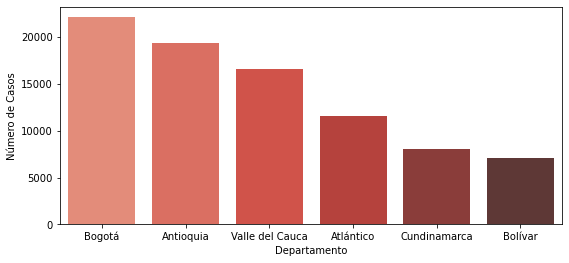

In [22]:
temp = df_main.groupby(by=["nombre_depto"]).sum().reset_index().sort_values(by="num_casos",ascending=False)
plt.figure(figsize=(9,4))
temp_fig = sns.barplot(y="num_casos", x="nombre_depto", data=temp, palette="Reds_d", order = temp["nombre_depto"][0:6])
temp_fig.set(xlabel='Departamento', ylabel='Número de Casos')
plt.show()

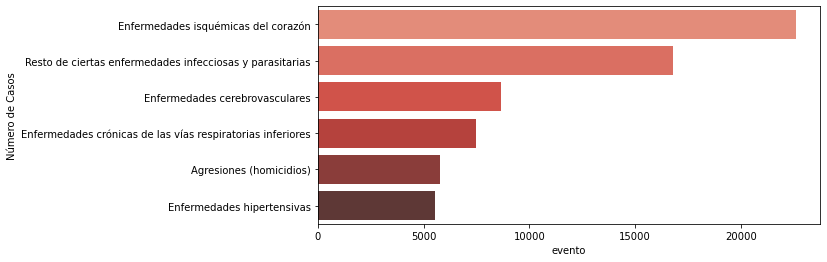

In [23]:
temp = df_main.groupby(by=["evento"]).sum().reset_index().sort_values(by="num_casos",ascending=False)
plt.figure(figsize=(9,4))
temp_fig = sns.barplot(y="evento", x="num_casos", data=temp, palette="Reds_d", order = temp["evento"][0:6])
temp_fig.set(xlabel='evento', ylabel='Número de Casos')
plt.show()